# Init

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import tempfile
import os
assert float(tf.__version__[:3]) >= 2.3
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from tensorflow.keras.callbacks import Callback
!pip install tensorflow-addons
import tensorflow_addons as tfa

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def normalize_img(currentImage, currentLabel):
    return tf.cast(currentImage, tf.float32)/ 255.0, currentLabel

def resize_img(currentImage, currentLabel):
    return tf.image.resize(currentImage,(32,32)), currentLabel

def flatten_img(currentImage, currentLabel):
    return tf.reshape(currentImage,[-1]), currentLabel

batchsize = 128

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16465223408632390225
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6588564460970389137
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

# prepare dataset

##mnist

In [233]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = mnist.load_data()

train_images_mnist = train_images_mnist.reshape(train_images_mnist.shape+(1,))
train_images_mnist = tf.image.resize(train_images_mnist,(32,32))
train_images_mnist = tf.reshape(train_images_mnist,[train_images_mnist.shape[0],-1])
test_images_mnist = test_images_mnist.reshape(test_images_mnist.shape+(1,))
test_images_mnist = tf.image.resize(test_images_mnist,(32,32))
test_images_mnist = tf.reshape(test_images_mnist,[test_images_mnist.shape[0],-1])
print(test_images_mnist.shape, train_images_mnist.shape)


# Normalize the input image so that each pixel value is between 0 to 1.
train_images_mnist = train_images_mnist.astype(np.float32) / 255.0
test_images_mnist = test_images_mnist.astype(np.float32) / 255.0

(10000, 1024) (60000, 1024)


##emnist

In [158]:
# (ds_train, ds_test), ds_info = tfds.load('emnist/byclass', split=['train[:1%]', 'test[:1%]'], as_supervised=True, shuffle_files=True, with_info=True,)
(ds_train, ds_test), ds_info = tfds.load('emnist/byclass', split=['train', 'test'], as_supervised=True, shuffle_files=True, with_info=True,)

def dataAug_emnist(currentImage, currentLabel):
    newSize = tf.random.uniform((1,), 18, 34)[0]
    rota = tf.random.uniform((1,), -15, 15)[0] * np.pi / 180
    currentImage = tfa.image.rotate(currentImage, rota)
    currentImage = tf.image.resize(currentImage, [newSize,newSize], method='bicubic')
    currentImage = tf.image.resize_with_crop_or_pad(currentImage, 36, 36)
    currentImage = tf.image.random_crop(currentImage, (32, 32, 1))
    currentImage = tf.where(currentImage>0.3, 1.0*tf.ones_like(currentImage), tf.zeros_like(currentImage))
    return currentImage, currentLabel

def transpose_emnist(currentImage, currentLabel):
    return currentImage.transpose([1,0,2]), currentLabel

ds_train = ds_train.map(transpose_emnist, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.map(dataAug_emnist, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(flatten_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batchsize, drop_remainder=True).prefetch(tf.data.AUTOTUNE) 


ds_test = ds_test.map(transpose_emnist, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(flatten_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batchsize, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

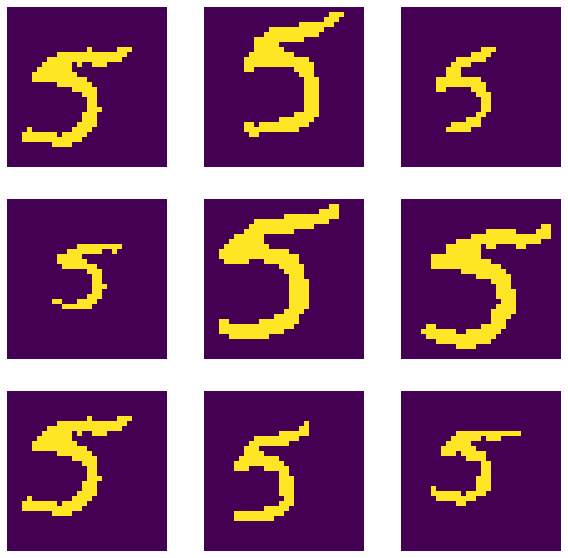

In [157]:
# print(next(iter(ds_train))[0])
# plt.imshow(next(ds_train.as_numpy_iterator())[0][12].reshape((32,32)))

plt.figure(figsize=(10, 10))
plt.title("Example of Training Inputs of Character e")
for i in range(9):
  augmented_image = next(ds_train.as_numpy_iterator())[0][117].reshape((32,32))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
  plt.axis("off")

# training

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.Input((1024,), batch_size=batchsize),
  tf.keras.layers.Reshape((32,32,1)),
  tf.keras.layers.Conv2D(filters=4 , kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),

  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64),
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (128, 32, 32, 1)          0         
                                                                 
 conv2d_6 (Conv2D)           (128, 32, 32, 4)          40        
                                                                 
 conv2d_7 (Conv2D)           (128, 30, 30, 8)          296       
                                                                 
 max_pooling2d_2 (MaxPooling  (128, 15, 15, 8)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (128, 15, 15, 8)          584       
                                                                 
 conv2d_9 (Conv2D)           (128, 13, 13, 16)         1168      
                                                      

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

model.fit(
  ds_train,
  epochs=20,
  batch_size=batchsize,
  validation_data=ds_test,
  callbacks=[EarlyStoppingAtMinLoss(2)],
)

Epoch 1/20
5452/5452 [==============================] - 381s 49ms/step - loss: 1.0902 - accuracy: 0.6743 - val_loss: 0.5889 - val_accuracy: 0.8000
Epoch 2/20
5452/5452 [==============================] - 248s 45ms/step - loss: 0.6467 - accuracy: 0.7837 - val_loss: 0.5070 - val_accuracy: 0.8240
Epoch 3/20
5452/5452 [==============================] - 247s 45ms/step - loss: 0.5851 - accuracy: 0.8008 - val_loss: 0.4997 - val_accuracy: 0.8272
Epoch 4/20
5452/5452 [==============================] - 249s 46ms/step - loss: 0.5578 - accuracy: 0.8081 - val_loss: 0.4847 - val_accuracy: 0.8293
Epoch 5/20
5452/5452 [==============================] - 250s 46ms/step - loss: 0.5393 - accuracy: 0.8135 - val_loss: 0.4878 - val_accuracy: 0.8268
Epoch 6/20
5452/5452 [==============================] - 251s 46ms/step - loss: 0.5278 - accuracy: 0.8159 - val_loss: 0.4569 - val_accuracy: 0.8364
Epoch 7/20
5452/5452 [==============================] - 248s 45ms/step - loss: 0.5197 - accuracy: 0.8185 - val_loss: 0

# fine-tune pre-trained model with quantization aware training

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

In [ ]:
q_aware_model.fit(ds_train, batch_size=batchsize,
         epochs=1, validation_data=ds_test)

# Convert model

## model_final with batchsize=1

In [ ]:
model_final = tf.keras.Sequential([
  tf.keras.Input((1024,), batch_size=1),
  tf.keras.layers.Reshape((32,32,1), batch_size=1),
  tf.keras.layers.Conv2D(filters=4 , kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),

  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64),
])

# Train the digit classification model
model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_final.set_weights(model.get_weights()) 

## from model

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images_mnist[:100000]).batch(1).take(1000):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmpzkkot5rv/assets


INFO:tensorflow:Assets written to: /tmp/tmpzkkot5rv/assets


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


## from  quantization aware training

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images_mnist[:100000]).batch(1).take(1000):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant_aware = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_aware)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

# Save the models as files

In [ ]:
!apt-get update
!apt-get install xxd

## from model

In [ ]:
tflite_model_quant_file = "quant_model.tflite"
open(tflite_model_quant_file, "wb").write(tflite_model_quant)
  
import os
basic_model_size = os.path.getsize(tflite_model_quant_file)

print("Model is %d bytes" % basic_model_size)
!echo "const unsigned char model[] = {" > /content/model.h
!cat quant_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Model is 18656 bytes
Header file, model.h, is 115,080 bytes.


## from quantization aware training

In [ ]:
tflite_model_quant_aware_file = "quant_aware_model.tflite"
open(tflite_model_quant_aware_file, "wb").write(tflite_model_quant_aware)
  
import os
basic_model_size = os.path.getsize(tflite_model_quant_aware_file)

print("Model is %d bytes" % basic_model_size)
!echo "const unsigned char model[] = {" > /content/model_aware.h
!cat quant_aware_model.tflite | xxd -i      >> /content/model_aware.h
!echo "};"                              >> /content/model_aware.h

import os
model_h_size = os.path.getsize("model_aware.h")
print(f"Header file, model_aware.h, is {model_h_size:,} bytes.")

# Test the TensorFlow Lite models on MNIST

In [202]:
# Helper function to run inference on a TFLite model
def run_tflite_model_mnist(tflite_file, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images_mnist[test_image_index]
    test_label = test_labels_mnist[test_image_index]
    test_image = (test_image * 255 - 128).astype(np.int8).reshape((1,1024))
    

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
    

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

import matplotlib.pylab as plt

## Helper function to test the models on one image
def test_model_mnist(tflite_file, test_image_index, model_type):

  predictions = run_tflite_model_mnist(tflite_file, [test_image_index])

  plt.imshow(test_images_mnist[test_image_index].reshape((32,32)))
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels_mnist[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

from sklearn.metrics import confusion_matrix

# Helper function to evaluate a TFLite model on all images
def evaluate_model_mnist(tflite_file, model_type, test_length):
  global test_images_mnist
  global test_labels_mnist

  test_image_indices = range(test_length)
  predictions = run_tflite_model_mnist(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels_mnist[:test_length]== predictions) * 100) / test_length

  print('%s model accuracy is %.4f%%' % (
      model_type, accuracy))
  
  return confusion_matrix(test_labels_mnist[:test_length], predictions)

In [190]:
# Change this to test a different image
test_image_index = 1

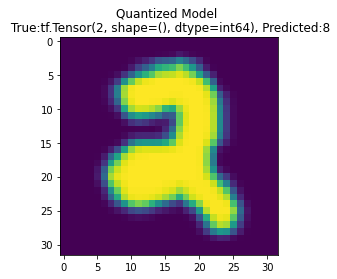

In [192]:
test_model_mnist(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [ ]:
test_model_mnist(tflite_model_quant_aware_file, test_image_index, model_type="Quantized")

Evaluate the quantized model:

Quantized model accuracy is 95.3800%
(10, 62)


([<matplotlib.axis.YTick at 0x7fd423410450>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9')])

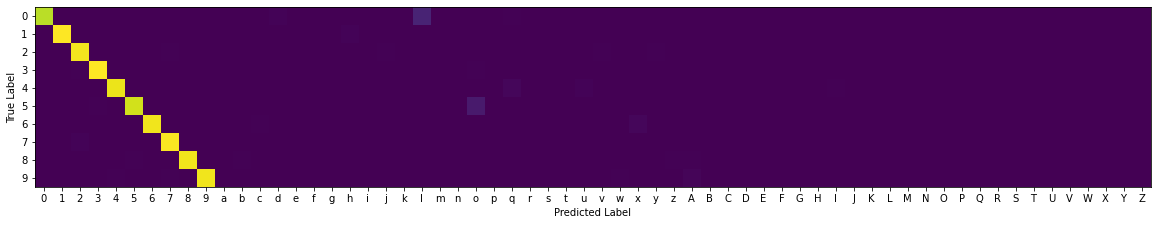

In [247]:
conf_m  = evaluate_model_mnist(tflite_model_quant_file, model_type="Quantized", test_length=10000)
conf_m = np.pad(conf_m, (0, 62-conf_m.shape[0]))
conf_m = conf_m[:10]
scale_m = np.sum(conf_m, axis=1)[:,np.newaxis]
conf_m = conf_m / scale_m
print(conf_m.shape)

labels = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

plt.figure(figsize=(20,20))
plt.imshow(conf_m)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(list(range(62)),labels)
plt.yticks(list(range(10)),labels)

Evaluate the quantized aware model:

In [ ]:
evaluate_model(tflite_model_quant_aware_file, model_type="Quantized")

# Evaluate the models on emnist


In [212]:
test_images_emnist,test_labels_emnist = tfds.load('emnist/byclass', split='test', as_supervised=True, batch_size=-1)
test_images_emnist = tf.image.transpose(test_images_emnist,[0,2,1,3])
test_images_emnist = tf.image.resize(test_images_emnist,(32,32))
test_images_emnist = tf.reshape(test_images_emnist,[test_images_emnist.shape[0],-1])
test_images_emnist = test_images_emnist.astype(np.float32) / 255.0
test_images_emnist = tf.where(test_images_emnist>0.3, 1.0*tf.ones_like(test_images_emnist), tf.zeros_like(test_images_emnist))
print(test_images_emnist.shape)

(116323, 1024)


In [213]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images_emnist[test_image_index]
    test_label = test_labels_emnist[test_image_index]
    test_image = (test_image * 255 - 128).astype(np.int8).reshape((1,1024))
    

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
    

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

import matplotlib.pylab as plt

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels_emnist

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images_emnist[test_image_index].reshape((32,32)))
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels_emnist[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

from sklearn.metrics import confusion_matrix

# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type, test_length=116323):

  test_image_indices = range(test_length)
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels_emnist[:test_length]== predictions) * 100) / test_length

  print('%s model accuracy is %.4f%%' % (
      model_type, accuracy))
  
  return confusion_matrix(test_labels_emnist[:test_length], predictions)

Quantized model accuracy is 83.7092%
(62, 62)
(62, 62)


([<matplotlib.axis.YTick at 0x7fd4234c1c90>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, 'a'),
  Text(0, 0, 'b'),
  Text(0, 0, 'c'),
  Text(0, 0, 'd'),
  Text(0, 0, 'e'),
  Text(0, 0, 'f'),
  Text(0, 0, 'g'),
  Text(0, 0, 'h'),
  Text(0, 0, 'i'),
  Text(0, 0, 'j'),
  Text(0, 0, 'k'),
  Text(0, 0, 'l'),
  Text(0, 0, 'm'),
  Text(0, 0, 'n'),
  Text(0, 0, 'o'),
  Text(0, 0, 'p'),
  Text(0, 0, 'q'),
  Text(0, 0, 'r'),
  Text(0, 0, 's'),
  Text(0, 0, 't'),
  Text(0, 0, 'u'),
  Text(0, 0, 'v'),
  Text(0, 0, 'w'),
  Text(0, 0, 'x'),
  Text(0, 0, 'y'),
  Text(0, 0, 'z'),
  Text(0, 0, 'A'),
  Text(0, 0, 'B'),
  Text(0, 0, 'C'),
  Text(0, 0, 'D'),
  Text(0, 0, 'E'),
  Text(0, 0, 'F'),
  Text(0, 0, 'G'),
  Text(0, 0, 'H'),
  Text(0, 0, 'I'),
  Text(0, 0, 'J'),
  Text(0, 0, 'K'),
  Text(0, 0, 'L'),
  Text(0, 0, 'M'),
  Text(0, 0, 'N'),
  Tex

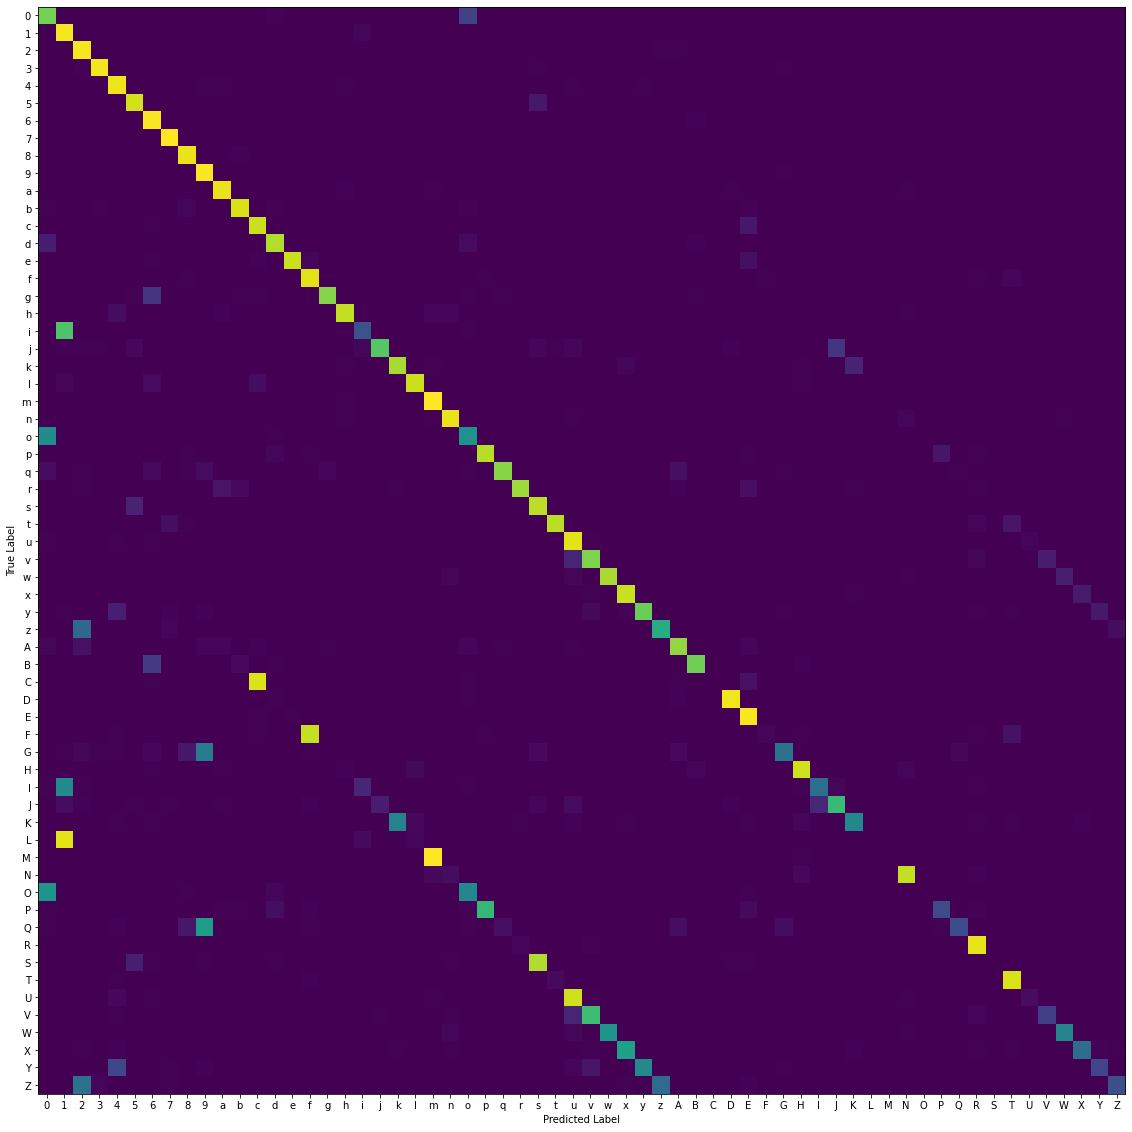

In [248]:
conf_m  = evaluate_model(tflite_model_quant_file, model_type="Quantized")
# print(conf_m)
print(conf_m.shape)
conf_m = np.pad(conf_m, (0, 62-conf_m.shape[0]))
scale_m = np.sum(conf_m, axis=1)[:,np.newaxis]
conf_m = conf_m / scale_m
print(conf_m.shape)

labels = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

plt.figure(figsize=(20,20))
plt.imshow(conf_m)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(list(range(62)),labels)
plt.yticks(list(range(62)),labels)